In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Problem : Principal Component Analysis
**Principal component analysis** (PCA) is a technique of dimensionality reduction, which linearly maps data onto a lower-dimensional space, so that the variance of the projected data in the associated dimensions would be maximized. In this problem, you will perform PCA on a dataset of face images.

In [2]:
X_train, X_test = [], []
Y_train, Y_test = [], []
for i in range(1,41):      #讀取40個人
    for j in range(1, 10): #每個人讀取前9張影像
        img = cv2.imread('data/{}_{}.png'.format(i, j), cv2.IMREAD_GRAYSCALE) #檔案以灰階格式讀取
        X_train.append(img)
        Y_train.append(i) #ground truth
    img = cv2.imread('data/{}_10.png'.format(i),cv2.IMREAD_GRAYSCALE) #每個人的第10張影像為test data
    X_test.append(img)
    Y_test.append(i)

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(360, 56, 46) (360,)
(40, 56, 46) (40,)


## 1. mean face & first four eigenfaces

In [3]:
X_train2 = X_train.reshape(len(Y_train),-1)
#X_train的維度為360, 56, 46，Y_train維度為360，故將X_train reshape成Y_train的維度
X_train2.shape

(360, 2576)

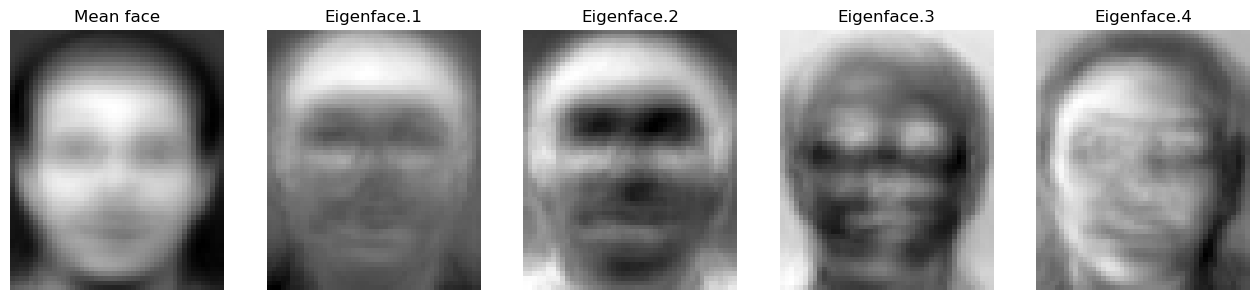

In [4]:
pca =PCA()
pca.fit(X_train.reshape(len(Y_train),-1)) 
plt.figure(figsize = (16,12))
plt.subplot(1,5,1)
plt.axis('off')
plt.title('Mean face')
plt.imshow(pca.mean_.reshape(X_train[0].shape), cmap='gray') #將pca的結果 reshape回原本的尺寸56*46

for i in range(4):
    plt.subplot(1,5,i+2)
    plt.axis('off')
    plt.title('Eigenface.{}'.format(i+1))
    plt.imshow(pca.components_[i].reshape(X_train[0].shape),cmap='gray')

plt.show()


## 2. Reconstruct person2 image1 using the first n = 3, 50, 170, 240, 345 eigenfaces
## 3. compute the mean squared error

[ 4.53750210e+02  3.23934588e+02 -6.95711890e+02 -2.57000564e+02
  6.65313676e+01  1.30617340e+02  4.71936786e+02  1.28878433e+02
  1.43145821e+02 -2.14149619e+02 -2.34948710e+02  2.11450722e+02
 -1.57881745e+02 -1.87883484e+02 -4.07868244e+02 -3.99370371e+01
  2.36495001e+02 -2.71036459e+02 -1.74150343e+02 -5.91050107e+01
  3.69722199e+01 -5.09209231e+01 -1.58570213e+02 -1.00393859e+02
  2.12420614e+02 -1.67278247e+02 -2.69085537e+02 -4.04300931e+01
  6.30464040e+01  1.09637618e+02  1.40039713e+02  1.54784445e+02
  8.15969174e+01  1.70102103e+02 -4.89765821e+01 -1.26241577e+02
  9.05330588e+01  2.05082483e+02 -1.17521636e+00  8.24851451e+01
 -3.98798186e+01 -9.51860282e+01 -7.71832999e+01 -6.04498578e+01
 -9.39189708e+01  1.56628564e+02 -1.21773833e+02  6.58666571e+00
  3.61332425e+01  5.64879228e+01 -1.30152657e+01 -5.42208642e+01
  8.89195855e+01 -9.27011720e+01 -1.17030989e+00  1.87296674e+01
  3.31988889e+01 -3.62156608e+01  9.08550356e+01  7.48519518e+01
  5.36311897e+00 -1.40275

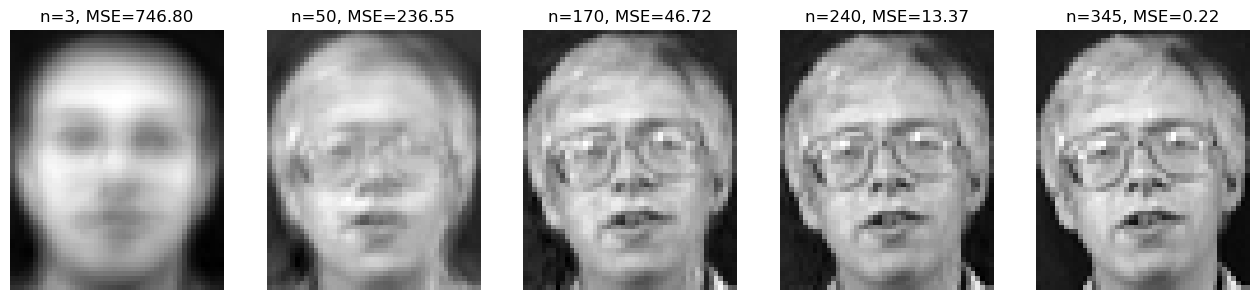

In [9]:
img = cv2.imread('data/2_1.png', cv2.IMREAD_GRAYSCALE).reshape(1,-1)
a = pca.transform(img)
#print(img.shape)
print(a[0])

plt.figure(figsize=(16,12))
n_components = [3,50,170,240,345]
for i, n in enumerate(n_components):
    face = np.zeros(img.shape)  #產生黑色的影像
    for j in range(n):
        face = face + a[0][j]*pca.components_[j] 
    face = face + pca.mean_                   #reconstruct pca回圖片
    MSE = np.mean((face - img)**2)
    plt.subplot(1,5,i+1)
    plt.axis('off')
    plt.title('n={}, MSE={:.2f}'.format(n,MSE))
    plt.imshow(face.reshape(X_train[0].shape), cmap = 'gray')


## 4. cross-validation results

In [28]:
reduced_X_train = pca.transform(X_train.reshape(len(Y_train),-1))
K = [1,3,5]
N = [3, 50, 170]
random = np.random.permutation(len(Y_train)) #將資料打亂
reduced_X_train = reduced_X_train[random]
Y_train_random = Y_train[random]
for k in K:
    print('K={}'.format(k))
    knn = KNeighborsClassifier(n_neighbors = k)
    for n in N:
        print('   n={},'.format(n), end='')
        score = cross_val_score(knn, reduced_X_train[:, :n], Y_train_random, cv=3) 
        #reduced_X_train[:, :n]代表取前面n個特徵；cv意指 cross validataion 要分成幾組
        print(' score={:.4f}'.format(score.mean())) #validation3組，score取平均值mean

K=1
   n=3, score=0.7500
   n=50, score=0.9778
   n=170, score=0.9750
K=3
   n=3, score=0.6639
   n=50, score=0.9222
   n=170, score=0.9167
K=5
   n=3, score=0.6222
   n=50, score=0.8694
   n=170, score=0.8444


## 5. recognition rate of the testing set

In [30]:
k = 1
n = 50

reduced_X_test = pca.transform(X_test.reshape(len(Y_test), -1))
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(reduced_X_train[:, :n], Y_train_random)

print('accuracy = {}'.format(knn.score(reduced_X_test[:, :n], Y_test)))

accuracy = 0.925
